---
# Librerias

In [14]:
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm

# Datos

In [2]:
%%time
all_files = glob.glob("*.csv")

df = pd.concat((pd.read_csv(f, header=0, usecols=["date", "nav", "isin"], 
                            parse_dates=True) for f in all_files))

# creo tabla pivot
df = pd.pivot_table(df, index='date', columns='isin', values = 'nav')
df.index = pd.to_datetime(df.index)

# elimino fines de semana
df = df[~df.index.dayofweek.isin([5,6])]

# elimino columnas con mas de 20% de nan
df = df.loc[:,df.isnull().sum() < df.shape[0]*0.2]
df.shape

Wall time: 25.7 s


(246, 57683)

<AxesSubplot:>

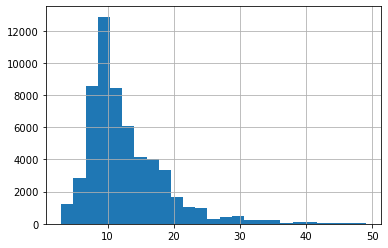

In [3]:
df.isnull().sum().hist(bins=25)

In [70]:
# en promedio faltan unos 10 datos por fondo.
# estoy cómodo con la cantidad y los relleno.

dffill = df.fillna(method="ffill")
dffill = dffill.fillna(method="bfill")

# Funciones

In [5]:
def generar_matrices_markowitz(tickers, q, n_stocks_max):
    """
    Genera las matrices aleatorias necesarias,
    devuelve una matriz de ponderaciones y otra con los activos que las componen.
    """
    # Matriz de ponderaciones aleatorias
    pond_random = np.random.rand(q, n_stocks_max)

    # Matriz de ceros y unos aleatorios
    unos_random = np.random.randint(2, size=(q, n_stocks_max))
    indices = np.where(~unos_random.any(axis=1))[0]
    # si alguna fila es todo ceros, no sirve, la cambio
    while indices.size > 0:
        for indice in indices:
            unos_random[indice] = np.random.randint(2, n_stocks_max)
            indices = np.where(~unos_random.any(axis=1))[0]

    # Multiplico para agregar los ceros a las ponderaciones
    pond_random = pond_random * unos_random

    # Escalo para que sumen 1
    suma_pond = np.matrix(np.sum(pond_random, axis=1))
    ponderacion = np.asarray(np.divide(pond_random, suma_pond.transpose()))

    # Seleccion de activos aleatorios
    activos_carteras = np.random.choice(tickers, size=(q, n_stocks_max))

    return ponderacion, activos_carteras

In [6]:
def simular_bruto(data, tickers, q, n_stocks_max, tasa_rf):
    """
    Simula "q" combinaciones de carteras y calcula su
    retorno, volatilidad, y ratio sharpe.
    """
    datos = []

    # retorno diario promedio
    retorno_medio = np.log(data.iloc[-1, :] / data.iloc[0, :]) / data.shape[0]

    # dataframe con los retornos logaritmicos
    data_log = np.log(data).diff().dropna()

    for n_stocks in n_stocks_max:

        # Genero las matrices
        ponderacion, activos_carteras = generar_matrices_markowitz(
            tickers, q, n_stocks_max=n_stocks
        )

        # armo el DF de resultados
        for i in range(q):
            # busco los activos que corresponde
            df = data_log[activos_carteras[i]]
            # calculo matriz de covarianzas
            mat_cov = df.cov()
            # genero diccionario con los resultados
            r = {}
            activos = list(activos_carteras[i])
            r["activos"] = activos
            r["pesos"] = ponderacion[i].round(3)
            pond = np.reshape(ponderacion[i] > 0, n_stocks)
            r["activos_con_peso"] = list(activos_carteras[i][pond])
            r["retorno"] = np.sum((retorno_medio[activos] * ponderacion[i] * 252))
            r["volatilidad"] = np.sqrt(
                np.dot(ponderacion[i], np.dot(mat_cov * 252, ponderacion[i]))
            )
            if r["volatilidad"] != 0:
                r["sharpe"] = round((r["retorno"] - tasa_rf) / r["volatilidad"], 3)
            else:
                r["sharpe"] = 0

            datos.append(r)

    datos = pd.DataFrame(datos).sort_values("sharpe", ascending=False)

    return datos

In [16]:
def simular_con_aprendizaje(
    data, lista_ticker, q_inicial, n_stocks_max, iteraciones, tasa_rf
):
    """
    Simula portafolios y en cada iteracion se queda con los activos que han
    contribuido a generar las mejores carteras por ratio de sharpe.
    Utiliza una funcion de decaimiento para tomar en cada iteracion, menos activos
    y realizar menos simulaciones de carteras.
    """
    # hacemoos una primer simulacion completa
    portfolios = simular_bruto(data, lista_ticker, q_inicial, n_stocks_max, tasa_rf)
    best = pd.DataFrame()

    # barra de progreso
    with tqdm(total=iteraciones, file=sys.stdout) as pbar:
        for i in np.arange(1, iteraciones + 1):
            pbar.update()
            # funcion de decaimiento
            decaimiento = int(q_inicial / (i * 2))
            # me quedo con carteras de mejor sharpe
            top = portfolios.iloc[:decaimiento]
            # me quedo con los tickers de estas carteras
            lista_tickers = list(top.activos_con_peso.apply(pd.Series).stack())
            # volvemos a simular solo con estos activos
            portfolios = simular_bruto(
                data, lista_ticker, decaimiento, n_stocks_max, tasa_rf
            )
            best = pd.concat([best, portfolios])

    best = best.sort_values("sharpe", ascending=False)

    return best

In [12]:
def markowitz(data, lista_ticker, q_inicial, n_stocks_max, iteraciones=10, tasa_rf=0):
    """
    Calcula con el uso de fuerza bruta un conjunto de carteras aleatorias.
    Busca reducir el universo de activos a los que aportan a los
    mejores sharpe ratio para obtener una frontera eficiente
    """

    best = simular_con_aprendizaje(
        data, lista_ticker, q_inicial, n_stocks_max, iteraciones, tasa_rf
    )

    tickers = best[:100].activos_con_peso.apply(pd.Series).stack()
    tickers = pd.unique(tickers)[: max(n_stocks_max)]

    q_inicial = int(q_inicial / 3)

    best = simular_con_aprendizaje(
        data, tickers, q_inicial, n_stocks_max, iteraciones, tasa_rf
    )
    best = best.sort_values("sharpe", ascending=False)

    return best

-------
# Ejecutamos

In [10]:
# lista de tickers
fondos = list(dffill.columns)

In [19]:
%%time

best_df = markowitz(dffill, fondos, 300000, n_stocks_max = [5, 10, 15, 20])

100%|██████████| 10/10 [17:49<00:00, 106.97s/it]
Wall time: 2h 25min 1s


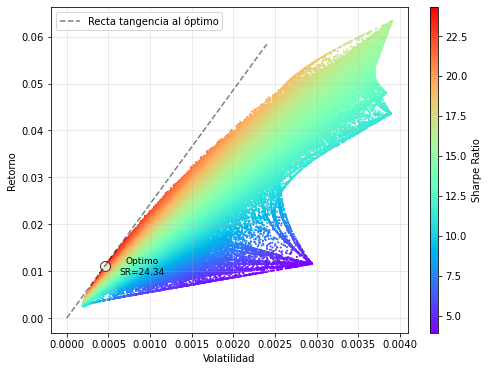

In [71]:
fig, ax = plt.subplots(figsize=(8, 6))
chart = ax.scatter(
    best_df.volatilidad, best_df.retorno, c=best_df.sharpe, s=1, cmap="rainbow"
)

fig.colorbar(chart, label="Sharpe Ratio", aspect=40)
ax.set_xlabel("Volatilidad")
ax.set_ylabel("Retorno")

optimo = best_df.iloc[0, :]
optimo_txt = f"Optimo\nSR={best_df.sharpe.max():.2f}"
ax.scatter(
    optimo.volatilidad, optimo.retorno, c="white", alpha=0.8, edgecolors="black", s=100
)
ax.text(
    optimo.volatilidad * 2,
    optimo.retorno,
    optimo_txt,
    fontsize=9,
    c="k",
    ha="center",
    va="center",
)

tasa_rf = 0
tg = [optimo.sharpe * x + tasa_rf for x in [i / 10000 for i in range(25)]]
ax.plot(
    [i / 10000 for i in range(25)],
    tg,
    "k--",
    alpha=0.5,
    label="Recta tangencia al óptimo",
)
ax.legend(loc="upper left")
ax.grid(alpha=0.3)

In [69]:
print(f"El Portafolio óptimo es compuesto por los siguientes activos con ponderación positiva, ISIN:\n{optimo.activos_con_peso}")
print(f"\nY sus ponderaciones son:\n{list(best_df.iloc[0,1][best_df.iloc[0,1]>0])}")
print(f"\nEl tiempo de ejecucion ha sido 2 horas con 25 minutos, en un procesador i5")

El Portafolio óptimo es compuesto por los siguientes activos con ponderación positiva, ISIN:
['IE00B74W3891', 'SG9999005961', 'JE00B5KXN372', 'LU0147471923', 'LU1799130890', 'LU0234773439', 'IE00B74W3891']

Y sus ponderaciones son:
[0.246, 0.24, 0.174, 0.019, 0.073, 0.044, 0.204]

El tiempo de ejecucion ha sido 2 horas con 25 minutos, en un procesador i5
